In [1]:
pip install --upgrade shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install dash

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [12]:
# Convert to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Fill NaN with MonthlyCharges × tenure  →  this is the BEST logical imputation!
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [5]:
no_internet = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in no_internet:
    df[col] = df[col].replace({'No internet service': 'No'})
df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})

In [6]:
X = df.drop(['Churn', 'customerID'], axis=1)
y = df['Churn']
X = pd.get_dummies(X, drop_first=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, scale_pos_weight=3)
model.fit(X_train, y_train)

print("Test Accuracy:", model.score(X_test, y_test))

Test Accuracy: 0.7530163236337828


In [8]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

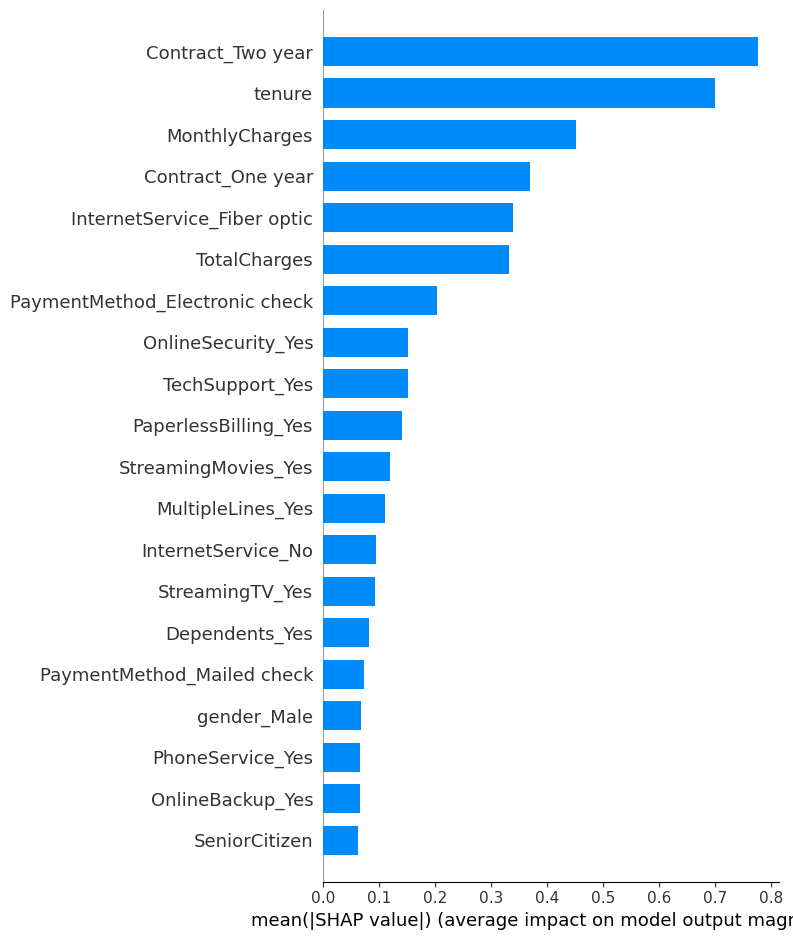

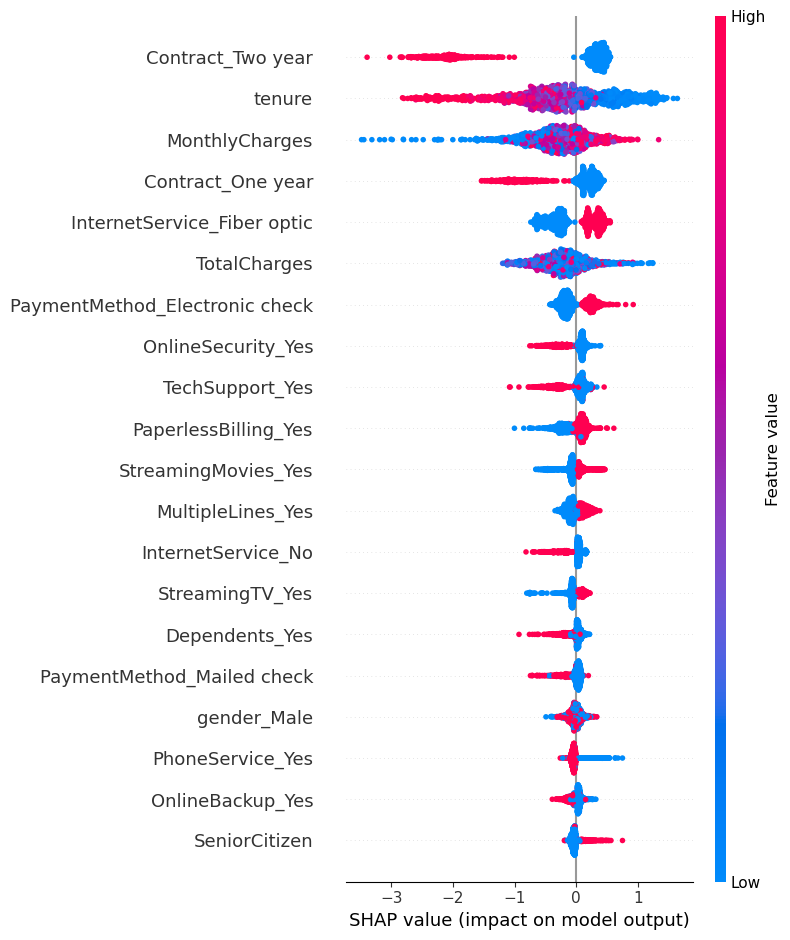

In [9]:
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Feature importance
shap.summary_plot(shap_values, X_test)              # Beeswarm (impact direction)

In [13]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
from xgboost import XGBClassifier
import joblib

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])
df = df.drop('customerID', axis=1)
df.replace({'No internet service': 'No', 'No phone service': 'No'}, inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [5]:
X = pd.get_dummies(df.drop('Churn', axis=1), drop_first=True)
y = df['Churn']
model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [6]:
FEATURE_NAMES = X.columns

In [7]:
# === 2. Dash App (Minimal & Beautiful) ===
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Telco Customer Churn Predictor", style={'textAlign': 'center', 'color': '#2c3e50'}),
    
    html.Div([
        html.Div([
            html.Label("Tenure (months)"),
            dcc.Slider(0, 72, 6, value=12, id='tenure'),
        ], style={'margin': '20px'}),
        
        html.Div([
            html.Label("Monthly Charges ($)"),
            dcc.Slider(18, 120, 5, value=70, id='monthly'),
        ], style={'margin': '20px'}),
        
        html.Div([
            html.Label("Contract Type"),
            dcc.Dropdown(['Month-to-month', 'One year', 'Two year'], 'Month-to-month', id='contract'),
        ], style={'margin': '20px'}),
        
        html.Div([
            html.Label("Internet Service"),
            dcc.Dropdown(['DSL', 'Fiber optic', 'No'], 'Fiber optic', id='internet'),
        ], style={'margin': '20px'}),
        
        html.Div([
            html.Label("Payment Method"),
            dcc.Dropdown([
                'Electronic check', 'Mailed check',
                'Bank transfer (automatic)', 'Credit card (automatic)'
            ], 'Electronic check', id='payment'),
        ], style={'margin': '20px'}),
    ], style={'maxWidth': '600px', 'margin': 'auto', 'fontFamily': 'Arial'}),
    
    html.Hr(),
    
    html.H2(id='prediction', style={'textAlign': 'center', 'fontSize': 28}),
    dcc.Graph(id='churn-pie'),
])

In [8]:
# === 3. Callback: Predict in Real-Time ===
@app.callback(
    [Output('prediction', 'children'), Output('churn-pie', 'figure')],
    [Input('tenure', 'value'),
     Input('monthly', 'value'),
     Input('contract', 'value'),
     Input('internet', 'value'),
     Input('payment', 'value')]
)
def predict_churn(tenure, monthly, contract, internet, payment):
    # Create input as DataFrame
    input_data = pd.DataFrame({
        'tenure': [tenure],
        'MonthlyCharges': [monthly],
        'TotalCharges': [monthly * tenure],  # good enough
        'Contract': [contract],
        'InternetService': [internet],
        'PaymentMethod': [payment],
        'gender': ['Male'],  # default (doesn't matter much)
        'SeniorCitizen': [0],
        'Partner': ['No'],
        'Dependents': ['No'],
        'PhoneService': ['Yes'],
        'MultipleLines': ['No'],
        'OnlineSecurity': ['No'],
        'OnlineBackup': ['No'],
        'DeviceProtection': ['No'],
        'TechSupport': ['No'],
        'StreamingTV': ['No'],
        'StreamingMovies': ['No'],
        'PaperlessBilling': ['Yes']
    })
    
    # Encode exactly like training data
    input_encoded = pd.get_dummies(input_data, drop_first=True)
    input_encoded = input_encoded.reindex(columns=FEATURE_NAMES, fill_value=0)
    
    # Predict
    prob = model.predict_proba(input_encoded)[0, 1]
    risk = "High Risk - Likely to Churn" if prob > 0.5 else "Low Risk - Likely to Stay"
    color = "crimson" if prob > 0.5 else "forestgreen"
    
    fig = px.pie(
        values=[prob, 1-prob],
        names=['Churn Risk', 'Will Stay'],
        hole=0.5,
        color_discrete_sequence=[color, '#95a5a6']
    )
    fig.update_layout(title=f"Churn Probability: {prob:.1%}", title_x=0.5)
    
    return f"{risk} ({prob:.1%} chance of leaving)", fig

In [10]:
# === 4. Run App ===
if __name__ == '__main__':
    app.run(debug=False, port=8050)